# Project description
Urban mobility significantly contributes to global environmental impact. With the growth in urbanareas worldwide, cities are implementing policies to focus on sustainable urban and mobility devel-opment. Urban areas exhibit high variability in structure, economic output, mobility behaviour,among others. Pinpointing to the exact causes of emissions is impossible. However, understandingthe relationship of mobility with infrastructure resources and other urban indicators may help gov-ernments predict long-term mobility behaviour and intervene with future pathways into sustainablemobility options. </br>

Project goals: You are tasked to identify how mobility is related to the infrastructural form of acity and across multiple cities. Use your findings toward helping governments transform mobilitywithin cities for reducing environmental impacts of mobility use.
Data: </br>
1. Local city-wide indicators of urban mobility: Multi-city Traffic Datasetprovided publicly byThe Institute for Transport Planning and Systems at ETH Zurich.
2. Global city-wide indicators of urban mobility and environmental impacts:Urban TypologiesProject[Reference]3.Get indicators for infrastructure resources from OSMNX (street networks) and PYROSM(amenities and points of interest) python packages.High-level project goals1.Explore, Investigate, and Visualize various factors of the mobility data across cities of interest.2.Describe and incorporate additional data sources that you will use to help you understandrelationships between mobility and the built environment.
3. Identify correlations between mobility and the built environment.4.Perform clustering or LISA analysis on city streets where congestion may be related stronglywith the presence of certain amenities. Think about how that may vary with distance toamenities.
4. Or, train and evaluate models using the mobility data (either as predictors or as the primaryresponse in some fashion) and your data sources.
6. Use and interpret your models to discuss the causes and correlations of or effects due todifferences in congestion across cities or within a city of your choice.
7. Aggregate city-wide findings to correlate with environmental indicators used in data set (2) -urban typology - to comment on policy initiatives of the governments. (Think how you mayaggregate city-wide findings to a single score for the whole city to compare with indicatorsused in data set 

(2))Note: Not all data may be available for all cities. Hence, conduct this analysis for at least5citiesoverlapping between sets1and2in the data. You are welcome to do the analysis in many morecities.


### UTD-19

### OSMNX

In [1]:
# import 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pyrosm as py

In [2]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe

### OSMNX Graph creation

In [3]:
def GetGraphs(clist, df):
    # function designed to extract bbox and create graphs with bbox
    GraphList = []
    for i in clist:
        maxlonglt = df.loc[df.citycode == i, ['long', 'lat']].max() # maxlonglat[0] = long, 1 lat
        minlonglt = df.loc[df.citycode == i, ['long', 'lat']].min() #
        north = maxlonglt[1] 
        south = minlonglt[1]
        east = maxlonglt[0]
        west = minlonglt[0]
        A = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
        GraphList.append(A)
    return GraphList
        
Graphs = GetGraphs(newcitylist, UTD19Cities)

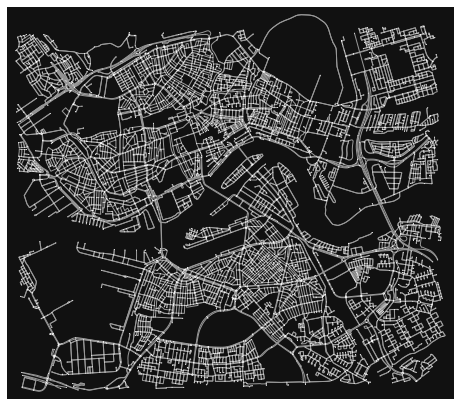

In [4]:
# example of plotting a graph
G1 = ox.project_graph(Graphs[1])
fig, ax = ox.plot_graph(G1, node_size=1)

In [5]:
# Edge attributes and node data
Rotterdam = Graphs[1]
node_data, edge_attributes = ox.graph_to_gdfs(Rotterdam) # Get node info and edge info

NameLink = pd.DataFrame(edge_attributes[['osmid','name']]) # only extract the osmid and road name
NameLink.rename({'name': 'road'}, inplace = True, axis = 1) # The Graph network has more raods in it than UTD
# some entries are a list of street names 
NameLink = NameLink.explode('road') # use this to create entry with same values, so road is not a list anymore
#NameLink = NameLink.explode('osmid') # some roads have two osmid -> explode

URotterdam = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam', ['detid', 'road']] #only get detid and road name

TranslateTable = pd.merge(NameLink, URotterdam, on = 'road', how = 'right')
TranslateTable.head() # links osmid and detid

,osmid,road,detid
0,48400943,Kreekhuizenlaan,GRT02_MORO_1811_2_1
1,7326948,Kreekhuizenlaan,GRT02_MORO_1811_2_1
2,7326613,Kreekhuizenlaan,GRT02_MORO_1811_2_1
3,7326943,Kreekhuizenlaan,GRT02_MORO_1811_2_1
4,7326613,Kreekhuizenlaan,GRT02_MORO_1811_2_1


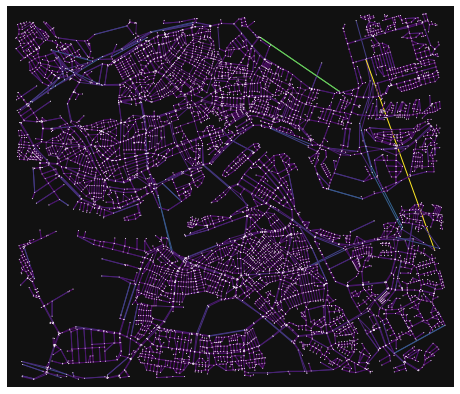

In [6]:
# way to add colors to edges
x = [1 if x%2 == 0 else 0 for x in edge_attributes.index] # create some random atribute

edge_attributes['X']=x # set att

WithX = ox.graph_from_gdfs(node_data, edge_attributes, graph_attrs={'edge_attr':'X'}) # graph_attrs and edge works it is safed! and able to call back
WithX.graph['crs'] = Rotterdam.graph['crs'] # need crs to plot
ec = ox.plot.get_edge_colors_by_attr(WithX, attr='length', cmap='viridis') # set color scale by atribute (now length could be any other variable)

G1 = ox.project_graph(WithX)
fig, ax = ox.plot_graph(G1, node_size=1, edge_color=ec) # edgecolor is stored in ec

# Urban typologies import


In [7]:
citylist = ['Munich', 'Rotterdam-Hague', 'Frankfurt', 'Hamburg', 'Zurich']
UrbanTypo = pd.read_excel('Data/FINAL-COMBINED-DATASET.xlsx')
Cities = UrbanTypo.loc[(UrbanTypo.City.isin(citylist))]
Cities.reset_index(inplace = True)
Cities.head()

,index,City,cityID,clusterID,Typology,Country,Car Modeshare (%),Public Transit Modeshare (%),Bicycle Modeshare (%),Walking Modeshare (%),...,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
0,98,Hamburg,99,9,MassTransit Heavyweight,Germany,42.00,18.00,12,28.00,...,0.016812,0.667477,0.273596,0.437481,0.747204,0.536597,0.035424,0.357805,0.313441,0.231415
1,99,Munich,100,9,MassTransit Heavyweight,Germany,37.00,21.00,14,28.00,...,0.021030,0.674947,0.142531,0.433690,0.779353,0.599366,0.033533,0.354032,0.236366,0.429755
2,101,Frankfurt,102,10,MassTransit Moderate,Germany,38.00,20.00,11,31.00,...,0.033763,0.080828,0.131759,0.403807,0.741574,0.625617,0.044672,0.323014,0.323657,0.342305
3,182,Rotterdam-Hague,183,10,MassTransit Moderate,Netherlands,49.00,17.00,16,18.00,...,NaN,0.356458,0.164029,0.484939,0.750362,0.540186,0.035450,0.204339,0.193488,0.508605
4,238,Zurich,239,10,MassTransit Moderate,Switzerland,42.92,46.31,4.14,5.65,...,0.025206,0.090735,0.346604,0.163072,1.000000,0.575431,0.025346,0.388853,0.185876,0.453369


# Fabians Merge

In [8]:
Rotterdam = Graphs[1]
node_data, edge_attributes = ox.graph_to_gdfs(Rotterdam) # Get node info and edge info
#switch first and second column
colnames=[]
for i, names in enumerate(edge_attributes.columns):
    colnames.append(names)
colnames[0]='name'
colnames[1]='osmid'
#print(colnames)
edge_attributes=edge_attributes.reindex(columns=colnames)
edge_attributes.head()

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0
2,Frans Bekkerstraat,7515679,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0
3,Verboomstraat,"[7515714, 7515628]",residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0
4,Schultz van Hagenstraat,7319072,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0


In [9]:
dfea=edge_attributes#chiller, want korter
dfea.loc[:,['name']]=np.nan_to_num(dfea.loc[:,['name']])

#create list to log whether a row contains a list for osmid
listornot=[]
for i in range(len(dfea.name)):
    if type(dfea.iloc[i,0]) == list:
        listornot.append(True)
    else:
        listornot.append(False)
#now append to df!
dfea['list?']=listornot
dfea.head(2)

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,list?
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,False
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,False


In [10]:
#save lists 
dfea_lists=dfea.loc[(dfea['list?'] == True)]
#save nonlists
dfea_nonlists=dfea.loc[(dfea['list?'] == False)]
dfea_lists=dfea_lists.reset_index()
#dfea_lists.drop(['index'])
dfea_lists=dfea_lists.iloc[:,1:17]
dfea_lists.shape

(649, 16)

In [11]:
#thrid try, also put appends in loop.
cdict = {name: [] for name in (dfea_lists.columns)} #make dict that consists out of lists equal to columns of df to fill below, with right names

for i in range (len(dfea_lists.name)):
    for j in range(len(dfea_lists.name[i])):
        ab=dfea_lists.name[i]
        cdict['name'].append(ab[j])
        for k, names_to_append in enumerate(dfea_lists.columns[1:len(dfea_lists.columns)]):
            l=k+1
            cdict[names_to_append].append(dfea_lists.iloc[i,l])
        
dfnew=pd.DataFrame.from_dict(cdict)
dfnew.head(2)
#works!

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
0,Pieter van der Wallenstraat,"[7315045, 7314958]",residential,False,127.547,NaN,"LINESTRING (4.5525434 51.9238523, 4.5526111 51...",NaN,NaN,NaN,NaN,NaN,NaN,44417036,44421114,0
1,Martinus Burkensstraat,"[7315045, 7314958]",residential,False,127.547,NaN,"LINESTRING (4.5525434 51.9238523, 4.5526111 51...",NaN,NaN,NaN,NaN,NaN,NaN,44417036,44421114,0


In [12]:
dfea_nonlists.reset_index(inplace = True, drop = True)
dfnew.reset_index(inplace=True, drop = True)
frames=[dfea_nonlists,dfnew]
final_set=pd.concat(frames)
final_set.head() # this is the final mergable set

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,list?
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,False
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,False
2,Frans Bekkerstraat,7515679,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0,False
3,Verboomstraat,"[7515714, 7515628]",residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0,False
4,Schultz van Hagenstraat,7319072,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0,False


In [13]:
final_set= final_set[final_set['name'].notna()]

In [14]:
# try merge?
TranslateTable.rename({'road':'name'}, inplace = True, axis =1)

#new_edges = final_set.merge(TranslateTable, on = 'name', how = 'right')
#new_edges.drop(['osmid_y', 'list?'], inplace = True, axis =1)
#new_edges.rename({'osmid_x': 'osmid'}, inplace = True, axis =1)
# 48400943
#new_edges.head(2)
TranslateTable.name.dropna(inplace = True)

In [15]:
TranslateTable=TranslateTable[TranslateTable['name'].notna()]

C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [17]:
straten=list(set(TranslateTable.name) & set(final_set.name))
len(straten)

55

In [18]:
print(len(straten))
print(len(TranslateTable))
print(len(final_set))
for i in range(len(straten)):
    print(straten[i])

55
9175
17335
Abram van Rijckevorselweg
Laan op Zuid
Westzeedijk
Prins Hendrikkade
Gordelweg
Nieuwe Boezemstraat
Coen Moulijnweg
Brielselaan
Pleinweg
Beukelsdijk
Abraham van Stolkweg
Droogdokweg
Statenweg
Schieweg
Zuiderparkweg
Groene Kruisweg
Burgemeester van Walsumweg
Dordtselaan
Doklaan
Maastunnel
Kralingse Zoom
's-Gravendijkwal
Boezemlaan
Vasteland
Vaanweg
Mathenesserbrug
Stadhoudersweg
Olympiaweg
IJsselmondse Randweg
Oldegaarde
Breitnerstraat
Pompenburg
Rochussenstraat
Victor Hugoweg
Stadionweg
Tjalklaan
Weena
Maasboulevard
Groeninx van Zoelenlaan
Waalhavenweg
Eemhavenweg
Goudsesingel
Vierhavensstraat
Bosdreef
Strevelsweg
Schiekade
Reeweg
Molenvliet
Kreekhuizenlaan
Schiedamsedijk
Westblaak
Adriaan Volkerlaan
Horváthweg
Putselaan
Hillelaan


In [21]:
tt_straten.head()

NameError: name 'tt_straten' is not defined

In [22]:
final_straten=final_set[final_set['name'].isin(straten)]
tt_straten=TranslateTable[TranslateTable['name'].isin(straten)]

C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
final_straten[final_straten["name"] =="Groeninx van Zoelenlaan"]
#heel veel lijken duplicates?

In [ ]:
tt_straten[tt_straten["name"] =="Groeninx van Zoelenlaan"]
#wederom op het zicht veel duplicates!

In [ ]:
TranslateTable.head()

In [ ]:
final_straten.head()

In [ ]:
tt_straten.drop_duplicates(subset=['detid'])

In [ ]:
tt_straten.
dic_tt_cleaned= {x: [] for x in (tt_straten.columns)}
for i, names in enumerate(tt_straten.name):
    if i>0:
        if (names[i] != names[i-1]):
            dic_tt_cleaned['name'].append(names[i])
dic_tt_cleaned

In [ ]:
final_straten.drop_duplicates(subset=['geometry'])

In [ ]:
Translatetable

In [ ]:
TranslateTable['detid'].nunique()

In [ ]:
pd.join

In [ ]:
#Testing
final_set['x'] = final_set.geometry.centroid.x
final_set['y'] = final_set.geometry.centroid.y

sns.scatterplot('x', 'y', data = final_set)

In [ ]:
# df = df[~df.datecolumn.isin(a)] idea

new_edges = final_set[~final_set.name.isin(TranslateTable.name)] # take only the edges of which the name is in translate table
new_edges.drop('list?', inplace = True, axis =1)
new_edges.reset_index(inplace = True, drop = True)

In [ ]:
x = new_edges.set_index('name', drop = True)
y = TranslateTable.set_index('name', drop = True)
y.head()

In [ ]:
z = x.join(y, how = 'right', lsuffix='l')
z.shape

In [ ]:
x = new_edges.merge(TranslateTable[['name','detid']], on = 'name', how = 'left') # namen komen helaas niet overeen? 

In [ ]:
x.shape

In [ ]:
# Creation of grahp
RotterdamII = ox.graph_from_gdfs(node_data, new_edges)
#new_edges.shape
#edge_attributes.shape
G1 = ox.project_graph(RotterdamII)
fig, ax = ox.plot_graph(G1, node_size=1)


### PYROSM Points of Interest

In [ ]:
# de filepaths zin nu specifiek voor mijn computer, moet je zelf even aanpassen naar waar die van jou staan
fp_rotterdam ="data/rotterdam.osm.pbf"
fp_munich ="data/munich.osm.pbf"
fp_zurich ="data/zurich.osm.pbf"
fp_hamburg ="data/hamburg.osm.pbf"
fp_frankfurt ="data/frankfurt.osm.pbf"

In [ ]:
for i in [fp_rotterdam, fp_munich, fp_zurich, fp_hamburg, fp_frankfurt]:
    # Initiliaze with bounding box
    osm = py.OSM(filepath=i)

    # Read POIs with custom filter 
    my_filter={'building': True} #"amenity": True, 'shop': True, }
    pois = osm.get_pois(custom_filter=my_filter)
    #print (pois.head(10))
    # Merge poi type information into a single column
    #pois["shop"] = pois["shop"].fillna(' ')
    #pois["amenity"] = pois["amenity"].fillna(' ')
    pois["building"] = pois["building"].fillna(' ')
    pois["poi_type"] = pois["building"] #+ pois["amenity"] + pois["shop"] 

    # Plot
    ax = pois.plot(column="poi_type", legend=True, markersize=4, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=2, bbox_to_anchor=(1, 1)))

In [ ]:
pois['x'] = pois.geometry.centroid.x
pois['y'] = pois.geometry.centroid.y


In [ ]:
pois.head()

In [ ]:
# create a hex binning map of the property locations
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(pois["x"], 
               pois["y"], 
               gridsize=20, 
              )
# Add a colorbar (optional)
ax.set_title('Hex binning map of property locations')
#ax.set_axis_off()
plt.colorbar(hb)

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(x = 'x', y = 'y', data = pois)